In [2]:
!pip install opencc
!pip install git+https://github.com/karpathy/minGPT.git > /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.2 MB/s eta 0:00:00:00:010:01
  Running command git clone --filter=blob:none --quiet https://github.com/karpathy/minGPT.git /tmp/pip-req-build-p7gz9x_u


In [3]:
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer
import pickle
from opencc import OpenCC
import random
from torch.utils.data.dataloader import DataLoader
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import unicodedata

def clean_file(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    cleaned_lines = []
    # print(len(lines))
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            en = parts[0].strip()
            zh = parts[1].strip()
            cleaned_lines.append(f"{en}\t{zh}")
    # print(parts)
    # print(len(cleaned_lines))
    with open(output_path, 'w', encoding='utf-8') as f:
        for line in cleaned_lines:
            f.write(line + '\n')

clean_file('/kaggle/input/cmn-eng/cmn.txt', 'eng-cmn.txt')

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeEn(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^\w\s]", "", s)  # 去掉所有标点
    s = re.sub(r"\s+", " ", s)
    return s.strip()

def normalizeCh(s):
    cc = OpenCC('t2s')  ##Traditional Chinese --> Simplified
    s = cc.convert(s) 
    s = s.replace(" ", "")
    s = re.findall(r'[\u4e00-\u9fa5]', s)
    s =  ''.join(s)
    return s

class TranslationDataset(Dataset):
    def __init__(self, split, filepath = "eng-cmn.txt", block_size=128):
        self.pairs = []
        with open(filepath, 'r', encoding='utf-8') as f:
            idx = 0
            for line in f:
                if '\t' in line:
                    en, zh = line.strip().split('\t')[:2]
                    zh = zh.replace(" ", "")
                    h = hash(pickle.dumps((zh, en)))
                    inp_split = 'test' if h % 10 == 0 else 'train'  # 10% for test dataset
                    if inp_split != split:
                        continue

                    self.pairs.append((normalizeCh(zh), normalizeEn(en)))
                idx += 1
                if (idx+1)%5000 == 0:
                    print(f"processing line {idx+1}")
            print(f"processsing line {len(self.pairs)}. Done.")
        
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.sep_token = "<sep>"
        self.eos_token = "<|endoftext|>"

        # if self.sep_token not in self.tokenizer.get_vocab():
        #     self.tokenizer.add_special_tokens({'additional_special_tokens': [self.sep_token, self.eos_token]})
        num_added = self.tokenizer.add_special_tokens({'additional_special_tokens': [self.sep_token]})

        self.block_size = block_size
        self.vocab = self.tokenizer.get_vocab()
        # self.vocab_size = list(self.vocab.items())[-1][1]
        # self.block_size = block_size
        self.vocab_size = len(self.tokenizer) 
        
        random.seed(9)
        random.shuffle(self.pairs)
        self.split = split

    def __len__(self):
        return len(self.pairs)

    
    def get_vocab_size(self):
        return self.vocab_size
    
    def get_block_size(self):
        return self.block_size

    def __getitem__(self, idx):
        zh, en = self.pairs[idx]
        
        # input = zh + <sep> + en + <eos>
        # full_text = zh + self.sep_token + en + self.eos_token

        encoded_zh = self.tokenizer(zh+self.sep_token, return_tensors="pt")["input_ids"].squeeze(0)
        encoded_en = self.tokenizer(en+self.eos_token, return_tensors="pt")["input_ids"].squeeze(0)

        cat = torch.cat((encoded_zh, encoded_en), dim=0)

        x = cat[:-1].clone()
        y = cat[1:].clone()
        sep_id = self.tokenizer.convert_tokens_to_ids(self.sep_token)
        eos_id = self.tokenizer.convert_tokens_to_ids(self.eos_token)
        y_start = y.tolist().index(sep_id)
        pad_x = torch.ones(self.block_size, dtype=torch.long) * eos_id
        pad_x[:len(x)] = x
        pad_y = torch.ones(self.block_size,dtype=torch.long) * (-1)
        # pad_y[:y_start+1] = -1
        pad_y[y_start+1:y_start+1+len(encoded_en)] = encoded_en
        # pad_y[y_start+1+len(encoded_en):] = -1

        # print("Chinese: ", zh, encoded_zh)
        # print(x)
        # print()
        # print("English: ", en, encoded_en)
        # print(y)
        # print()
        # print("with padding:")
        # print("x = ", pad_x)
        # print("y = ", pad_y )
        
        return  pad_x, pad_y


In [5]:
train_dataset = TranslationDataset('train')
test_dataset = TranslationDataset('test')
# print(len(train_dataset.pairs),len(test_dataset.pairs))

processing line 5000
processing line 10000
processing line 15000
processing line 20000
processing line 25000
processsing line 26784. Done.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

processsing line 3125. Done.


In [6]:
from mingpt.model import GPT

print(train_dataset.get_vocab_size())
print(train_dataset.get_block_size())

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-micro'
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

50258
128
number of parameters: 7.24M


In [7]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4
train_config.max_iters = 3000
train_config.num_workers = 0
train_config.batch_size = 64
train_config.n_layer = 4
train_config.weight_decay =0.05
trainer = Trainer(train_config, model, train_dataset)

running on device cuda


In [8]:
training_losses = []
def batch_end_callback(trainer):
    if trainer.iter_num % 20 == 0:
        training_losses.append(trainer.loss.item())
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 10.85928
iter_dt 169.70ms; iter 100: train loss 5.54375
iter_dt 171.80ms; iter 200: train loss 5.01476
iter_dt 177.40ms; iter 300: train loss 4.59358
iter_dt 184.06ms; iter 400: train loss 4.32011
iter_dt 192.99ms; iter 500: train loss 4.26146
iter_dt 197.63ms; iter 600: train loss 4.24192
iter_dt 196.24ms; iter 700: train loss 3.90694
iter_dt 190.32ms; iter 800: train loss 3.87248
iter_dt 190.27ms; iter 900: train loss 3.71157
iter_dt 193.48ms; iter 1000: train loss 3.72306
iter_dt 193.61ms; iter 1100: train loss 3.45928
iter_dt 195.06ms; iter 1200: train loss 3.48277
iter_dt 192.01ms; iter 1300: train loss 3.38218
iter_dt 192.86ms; iter 1400: train loss 3.40730
iter_dt 193.39ms; iter 1500: train loss 3.47313
iter_dt 189.83ms; iter 1600: train loss 3.21584
iter_dt 195.31ms; iter 1700: train loss 3.44062
iter_dt 193.86ms; iter 1800: train loss 3.04424
iter_dt 193.68ms; iter 1900: train loss 3.05526
iter_dt 194.33ms; iter 2000: train loss 2.86603
iter_

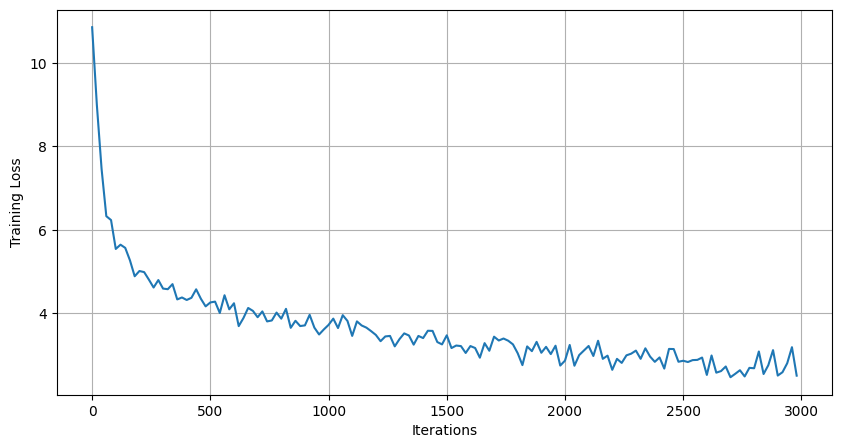

In [10]:
plt.figure(figsize = (10,5))
plt.plot(np.arange(len(training_losses))*20, training_losses)
plt.xlabel("Iterations")
plt.ylabel("Training Loss")
plt.grid()

## Train data generated examples

In [18]:
loader = DataLoader(train_dataset, batch_size=1, num_workers=0, drop_last=False)
tmp_train = {}

for b,(x, y) in enumerate(loader):
    if b in range(1007, 1017, 1):
        x = x.to(trainer.device)
        y = y.to(trainer.device)
        # print(x,y)
        sep_id = train_dataset.tokenizer.convert_tokens_to_ids("<sep>")
        sep_idx = x.tolist()[0].index(sep_id)
        inp = x[:,:sep_idx]
        sol_can = model.generate(inp, 128, do_sample=False)
        tokens = y.cpu().tolist()[0]
        #ground truth
        gt = []
        for i in tokens:
            if i != -1:
                gt.append(i)
        gt_sentence = train_dataset.tokenizer.decode(gt, skip_special_tokens=True)
        
        with torch.no_grad():
            generate_sol = sol_can.cpu().tolist()[0]    
        decoded_text = train_dataset.tokenizer.decode(generate_sol, skip_special_tokens=True)
        for i in range(len(decoded_text)): 
            if decoded_text[i] in train_dataset.vocab:
                break
        zh = decoded_text[:i]
        translation = decoded_text[i:]

        print(f"Input:  {zh}")
        print(f"Ground truth: {gt_sentence}")
        print(f"Translation: {translation}")
        print()

Input:  我每天都说英语 
Ground truth: i speak english every day
Translation: speak english every day

Input:  我也哭了 
Ground truth: i cried too
Translation: crying too

Input:  这家工厂生产电炉 
Ground truth: this factory manufactures electric stoves
Translation: a little boy

Input:  他喜欢足球胜过棒球 
Ground truth: he prefers football to baseball
Translation: like playing baseball

Input:  现在楼里没人 
Ground truth: theres no one in the building now
Translation: isnt in the table

Input:  那有点难以置信 
Ground truth: thats a little hard to believe
Translation: is difficult to believe

Input:  海啸来了密切注意啊 
Ground truth: a tsunami is coming so please be on the alert
Translation: is too difficult to keep his letter

Input:  就个人而言我赞同这个计划 
Ground truth: i for one am for the plan
Translation: and i have a plan to have a plan

Input:  这个女孩没有母亲 
Ground truth: the girl has no mother
Translation: two children

Input:  他问我是否很忙 
Ground truth: he asked me if i was busy
Translation: me a lot of books



## Test data generated example

In [11]:
model.eval()
loader = DataLoader(test_dataset, batch_size=1, num_workers=0, drop_last=False)

output = {}

for b,(x, y) in enumerate(loader):

    x = x.to(trainer.device)
    y = y.to(trainer.device)
    # print(x,y)
    sep_id = train_dataset.tokenizer.convert_tokens_to_ids("<sep>")
    sep_idx = x.tolist()[0].index(sep_id)
    inp = x[:,:sep_idx]
    # print(inp)
    sol_can = model.generate(inp, 128, do_sample=False)

    tokens = y.cpu().tolist()[0]
    #ground truth
    gt = []
    for i in tokens:
        if i != -1:
            gt.append(i)
    gt_sentence = test_dataset.tokenizer.decode(gt, skip_special_tokens=True)
    
    with torch.no_grad():
        generate_sol = sol_can.cpu().tolist()[0]    
    decoded_text = test_dataset.tokenizer.decode(generate_sol, skip_special_tokens=True)
    for i in range(len(decoded_text)): 
        if decoded_text[i] in train_dataset.vocab:
            break
    zh = decoded_text[:i]
    translation = decoded_text[i:]

    output[b] = {"input": zh,
                 "ground_truth": gt_sentence,
                 "translation": translation}

    
    if (b+1) % 300 == 0:
        print(f"Input:  {zh}")
        print(f"Ground truth: {gt_sentence}")
        print(f"Translation: {translation}")
        print()


Input:  医生告诉我我应该停止吸烟 
Ground truth: the doctor told me i had to stop smoking
Translation: of the doctor told me to be more

Input:  请关上门
Ground truth: please close the door
Translation: please turn on the door

Input:  你想吃这个吗 
Ground truth: do you want to eat this
Translation: eat this letter you want to

Input:  既然母亲病了我就待在家里没去上学 
Ground truth: since my mother was sick i stayed home from school
Translation: home in the house in the house wasnt in the house morning

Input:  他及时赴约了 
Ground truth: he was in time for the appointment
Translation: out of the train

Input:  这样做的话什么都不会改变的 
Ground truth: it wont change anything
Translation: nothing to do with anything

Input:  雨让我们没有办法去散步 
Ground truth: rain prevented us from taking a walk
Translation: to go to the party

Input:  我什么都不知道 
Ground truth: i dont know anything
Translation: i know anything

Input:  注意小偷 
Ground truth: beware of thieves
Translation: swim like

Input:  他十分钟前离开了 
Ground truth: he left ten minutes ago
Translation: out o

In [12]:
with open("generate_output.json", "w",encoding='utf-8') as f:
    json.dump(output, f, ensure_ascii=False, indent=4)
    

In [22]:
import json
import pandas as pd

def read_output(lst, data):
    tmp = []
    for i in lst:
        tmp.append(list(data[str(i)].values()))
    df = pd.DataFrame(tmp, columns=["Input  ", "Ground truth  ", "Translation  "])
    with pd.option_context('display.max_colwidth', 40, 'display.unicode.east_asian_width', True):
        print(df.to_string(index=False, justify='right'))
    # print(df)

with open ("generate_output.json", "r",encoding='utf-8') as f:
    data = json.load(f)

# manually go over the first half outputs
good = [226, 804, 856,1044,1508]
moderate = [245, 501,1374, 1490, 1543, 1568]
read_output(good, data)
print()
read_output(moderate, data)

              Input                 Ground truth                Translation  
    我正在做我的作业          im doing my homework             do my homework
我收到了朋友的一封信  i got a letter from a friend    a letter from my friend
        你会弹吉他吗       can you play the guitar be able to play the guitar
      我是一名大学生        i am a college student       is a student student
        他是医生来的                he is a doctor                is a doctor

                  Input                      Ground truth                           Translation  
            他比我高两寸  he is two inches taller than i am                   is taller than i am
              您能帮我吗                    can you help me                               help me
我舅母做了一条新裙子给我    my aunt made a new skirt for me                        me a new skirt
  我会在星期一给你打电话             ill call you on monday will call you up at the telephone you
          我爸爸在花园里           my fathers in the garden                    in the park father
              你愿意来吗  